In [1]:
import warnings
warnings.filterwarnings('ignore')
from pandas_datareader import data as pdr
from pandas_datareader.data import DataReader
import pandas as pd
import numpy as np
import itertools
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
%matplotlib inline
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import SimpleExpSmoothing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.optimize import minimize              # for function minimization
import scipy.stats as scs 

In [2]:
df = pd.read_csv(r'..\EDA\techlist.csv')

df['Date'] = pd.to_datetime(df['Date'])
# Set the date as index 
df = df.set_index('Date')

# Select the proper time period for daily aggreagation
# When mean() problem, because NAN shares on weekends(miss data)
df = df['2016-01-02':'2020-12-05'].resample('D').sum()
df.head()

# df=df.dropna()
# pd.isnull(df).sum()

High          Low         Open        Close       Volume  \
Date                                                                          
2016-01-04  1565.208467  1516.818005  1561.416477  1540.399515  389882800.0   
2016-01-05  1562.260469  1525.922543  1555.809498  1537.423494  306291700.0   
2016-01-06  1547.112471  1506.393480  1510.959999  1535.123016  357685900.0   
2016-01-07  1526.390501  1478.061522  1507.567987  1488.782516  431344000.0   
2016-01-08  1514.795494  1472.104002  1506.819485  1474.939962  380012500.0   

              Adj Close  
Date                     
2016-01-04  1530.806570  
2016-01-05  1527.870377  
2016-01-06  1525.684675  
2016-01-07  1479.652880  
2016-01-08  1465.815071

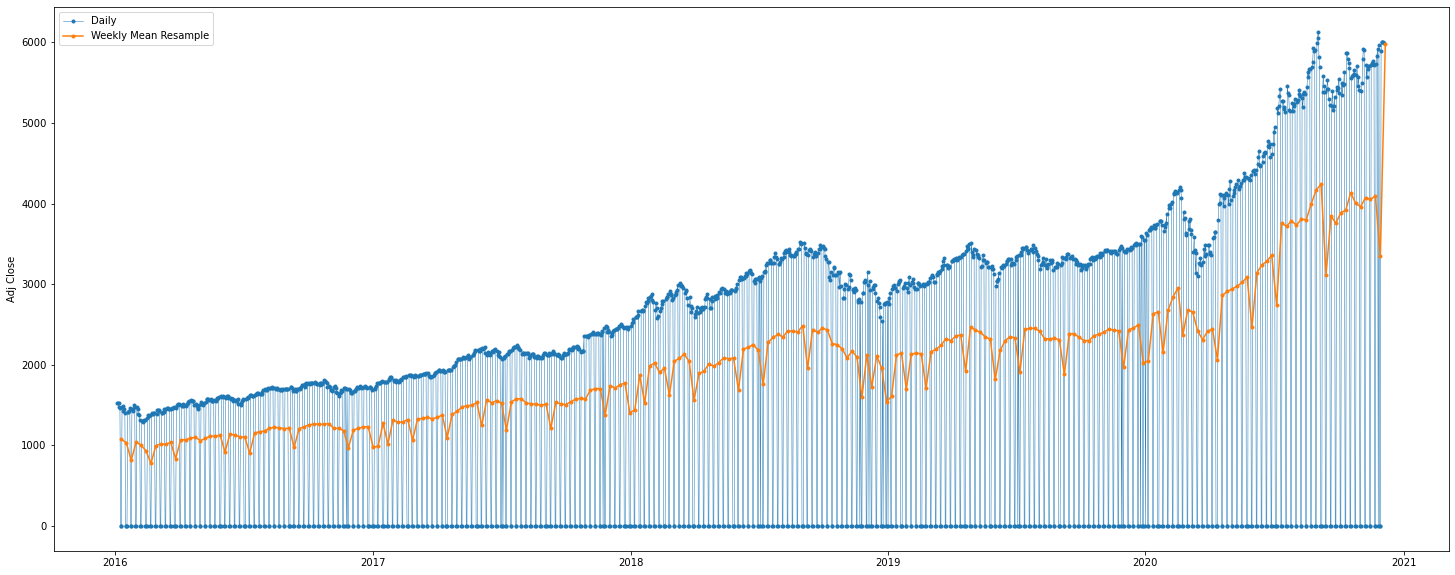

In [3]:
adj_close = df['Adj Close']
fig, ax = plt.subplots(figsize=(25, 10))
ax.plot(adj_close,marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(adj_close.resample('W').mean(),marker='o', markersize=3, linestyle='-', label='Weekly Mean Resample')
ax.set_ylabel('Adj Close')
ax.legend();

Decompose the data to view more of the complexity behind the linear visualization. 

A useful Python function called seasonal_decompose within the 'statsmodels' package can help us to decompose the data into four different components

#### Seasonal decomposition using moving averages (Naive decomposition)

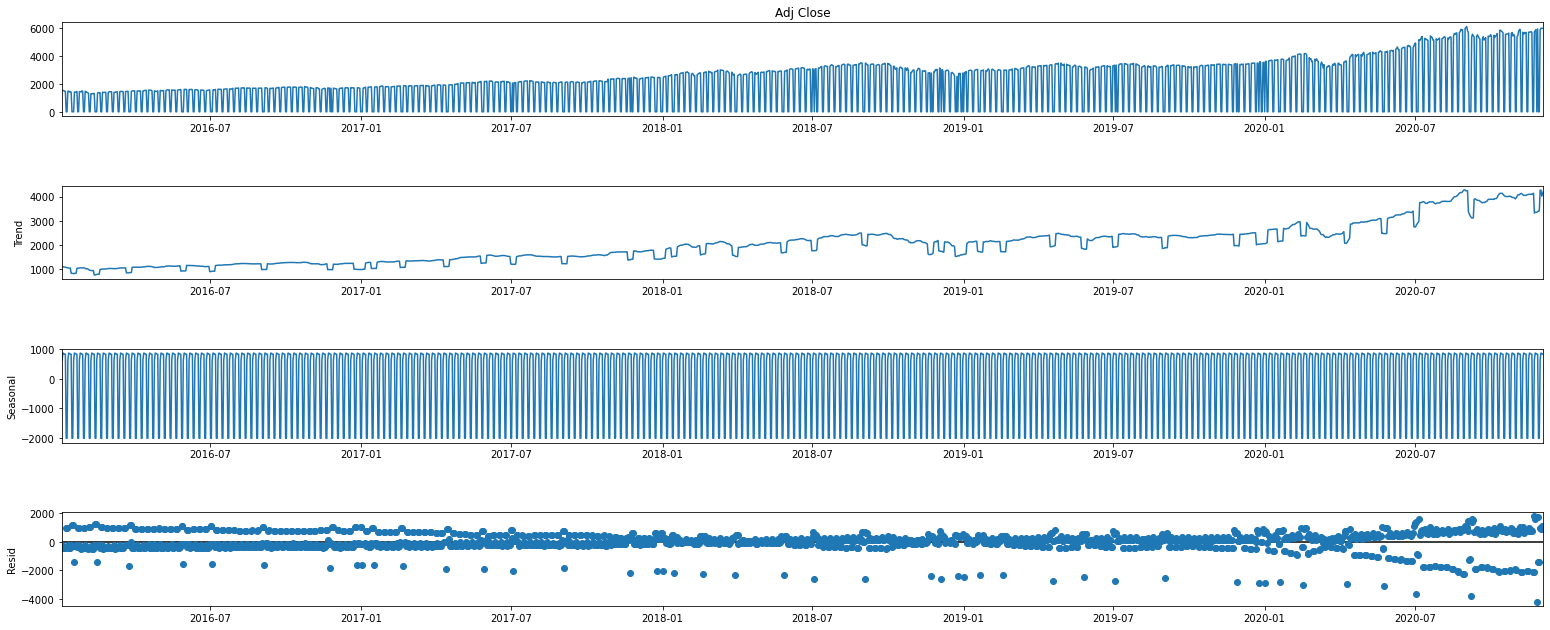

In [4]:
# graphs to show seasonal_decompose
def seasonal_decompose (adj_close):
    decomposition = sm.tsa.seasonal_decompose(adj_close, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(25, 10)
    plt.show()
    
seasonal_decompose(adj_close)

#### STL(Seasonal decomposition trend with LOESS)

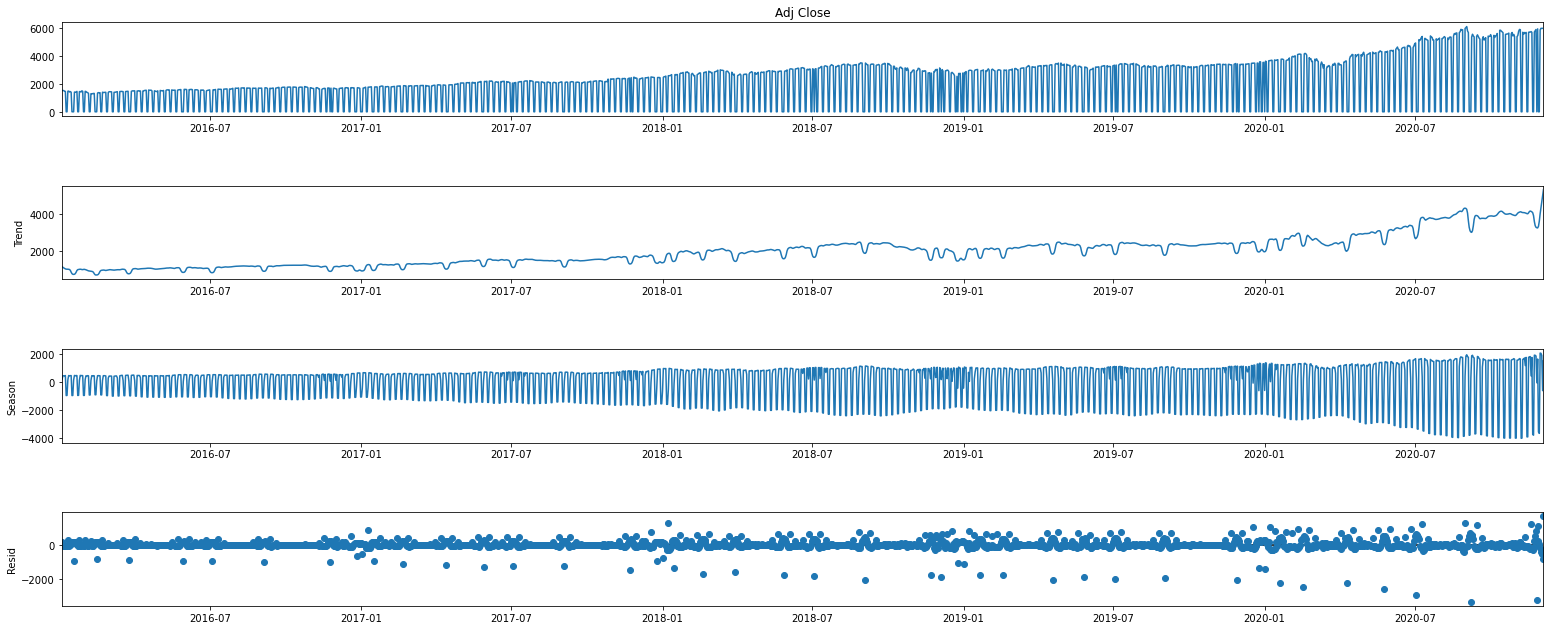

In [5]:
# graphs to show stl_decompose
def stl_decompose (adj_close):
    decomposition = STL(adj_close).fit()
    fig = decomposition.plot()
    fig.set_size_inches(25, 10)
    plt.show()

stl_decompose(adj_close)

### Check for Stationarity:
Next, we need to check whether the dataset is stationary or not. A dataset is stationary if its statistical properties like mean, variance, and autocorrelation do not change over time.

Most time series datasets related to business activity are not stationary since there are usually all sorts of non-stationary elements like trends and economic cycles. But, since most time series forecasting models use stationarity—and mathematical transformations related to it—to make predictions, we need to ‘stationarize’ the time series as part of the process of fitting a model.

Two common methods to check for stationarity are Visualization and the Augmented Dickey-Fuller (ADF) Test. Python makes both approaches easy:

### Visualization
This method graphs the rolling statistics (mean and variance) to show at a glance whether the standard deviation changes substantially over time:

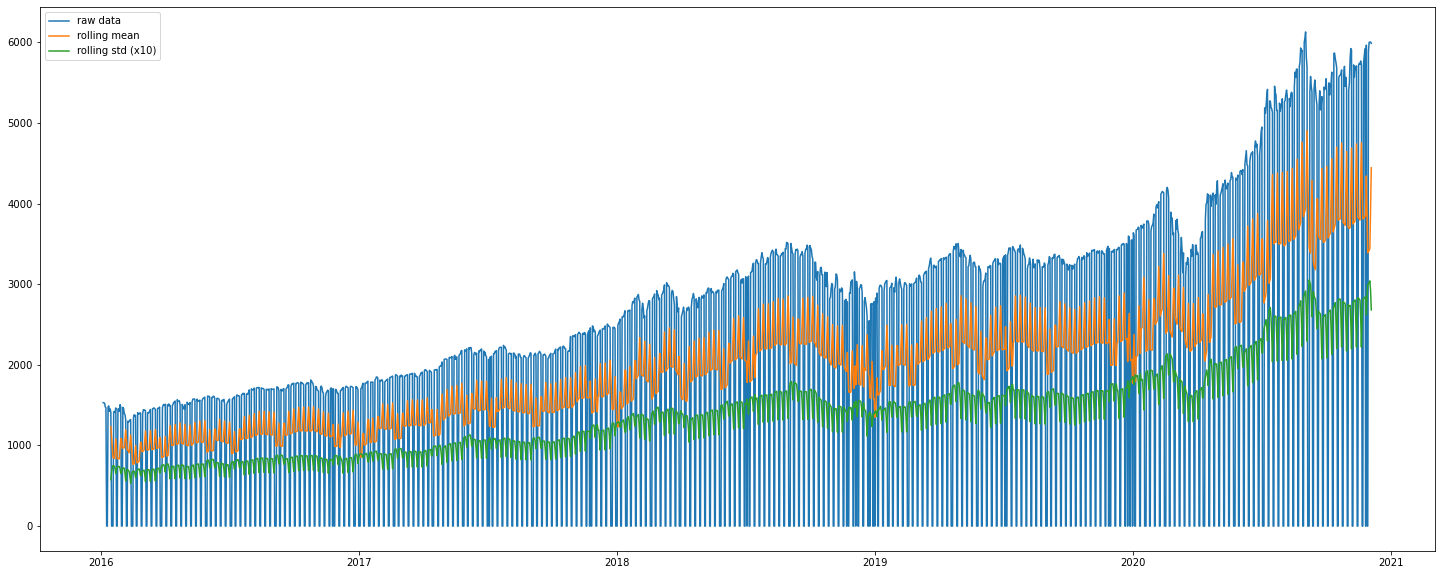

In [6]:
# plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(25, 10))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()
    
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(adj_close,'raw data')

### Another test of stationarity
### Augmented Dickey-Fuller Test
The ADF approach is essentially a statistical significance test that compares the p-value with the critical values and does hypothesis testing. Using this test, we can determine whether the processed data is stationary or not with different levels of confidence

In [7]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))
        
ADF_test(adj_close,'raw data')

 > Is the raw data stationary ?
Test statistic = -0.167
P-value = 0.942
Critical values :
	1%: -3.4340373743018104 - The data is not stationary with 99% confidence
	5%: -2.8631687706662676 - The data is not stationary with 95% confidence
	10%: -2.567637106781613 - The data is not stationary with 90% confidence


### Make the Data Stationary
we’ll use de-trending, differencing, and then a combination of the two.

### Detrending
This method removes the underlying trend in the time series:

 > Is the de-trended data stationary ?
Test statistic = -13.835
P-value = 0.000
Critical values :
	1%: -3.4340709449678415 - The data is  stationary with 99% confidence
	5%: -2.8631835901181564 - The data is  stationary with 95% confidence
	10%: -2.567644997740186 - The data is  stationary with 90% confidence


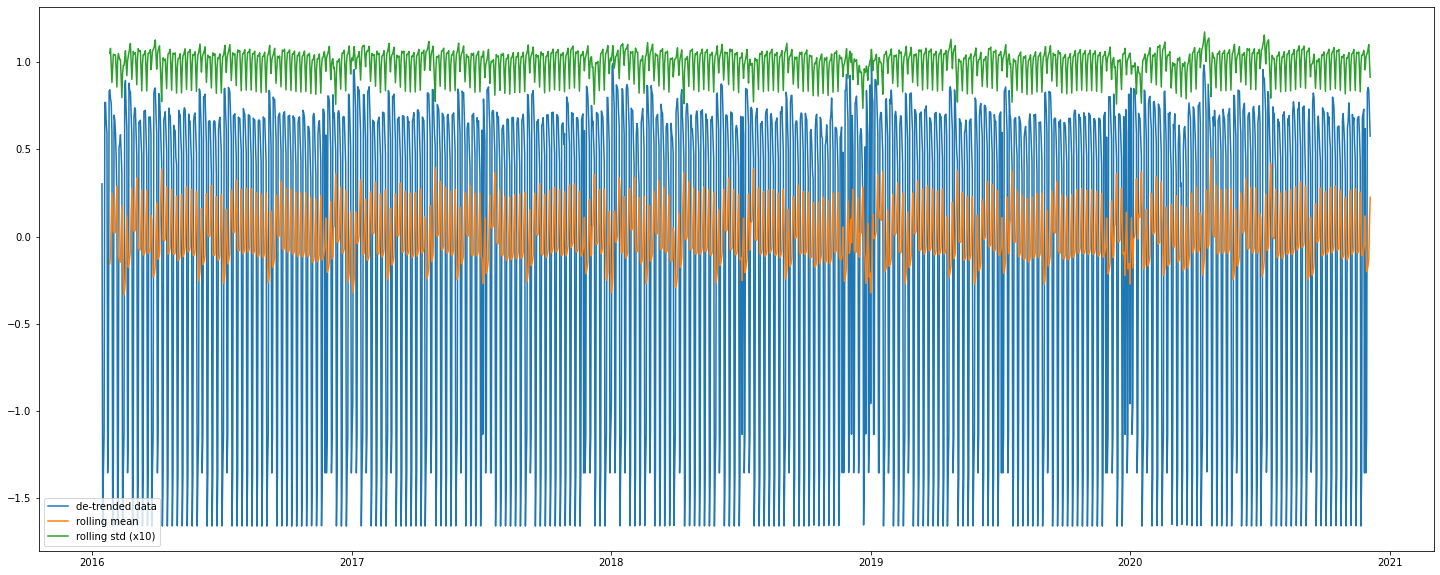

In [8]:
# Detrending
adj_close_detrend =  (adj_close - adj_close.rolling(window=12).mean())/adj_close.rolling(window=12).std()

test_stationarity(adj_close_detrend,'de-trended data')
ADF_test(adj_close_detrend,'de-trended data')

The results show that the data is now stationary, indicated by the relative smoothness of the rolling mean and rolling standard deviation after running the ADF test again.

### Differencing
This method removes the underlying seasonal or cyclical patterns in the time series. Since the sample dataset has a 12-month seasonality, I used a 12-lag difference:

 > Is the 12 lag differenced data stationary ?
Test statistic = -12.106
P-value = 0.000
Critical values :
	1%: -3.4340730634421153 - The data is  stationary with 99% confidence
	5%: -2.8631845252929495 - The data is  stationary with 95% confidence
	10%: -2.5676454956964605 - The data is  stationary with 90% confidence


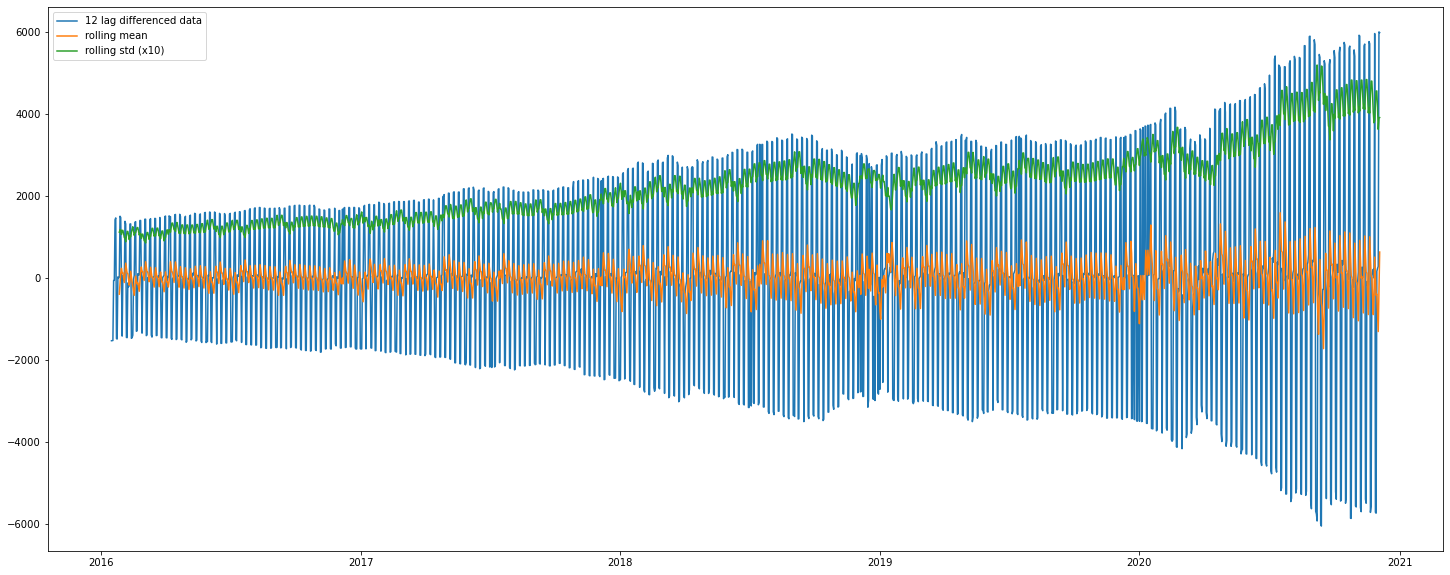

In [9]:
# Differencing
adj_close_12lag =  adj_close - adj_close.shift(12)

test_stationarity(adj_close_12lag,'12 lag differenced data')
ADF_test(adj_close_12lag,'12 lag differenced data')

### Combining Detrending and Differencing

 > Is the 12 lag differenced de-trended data stationary ?
Test statistic = -15.792
P-value = 0.000
Critical values :
	1%: -3.4340965268715795 - The data is  stationary with 99% confidence
	5%: -2.863194882895319 - The data is  stationary with 95% confidence
	10%: -2.5676510108577832 - The data is  stationary with 90% confidence


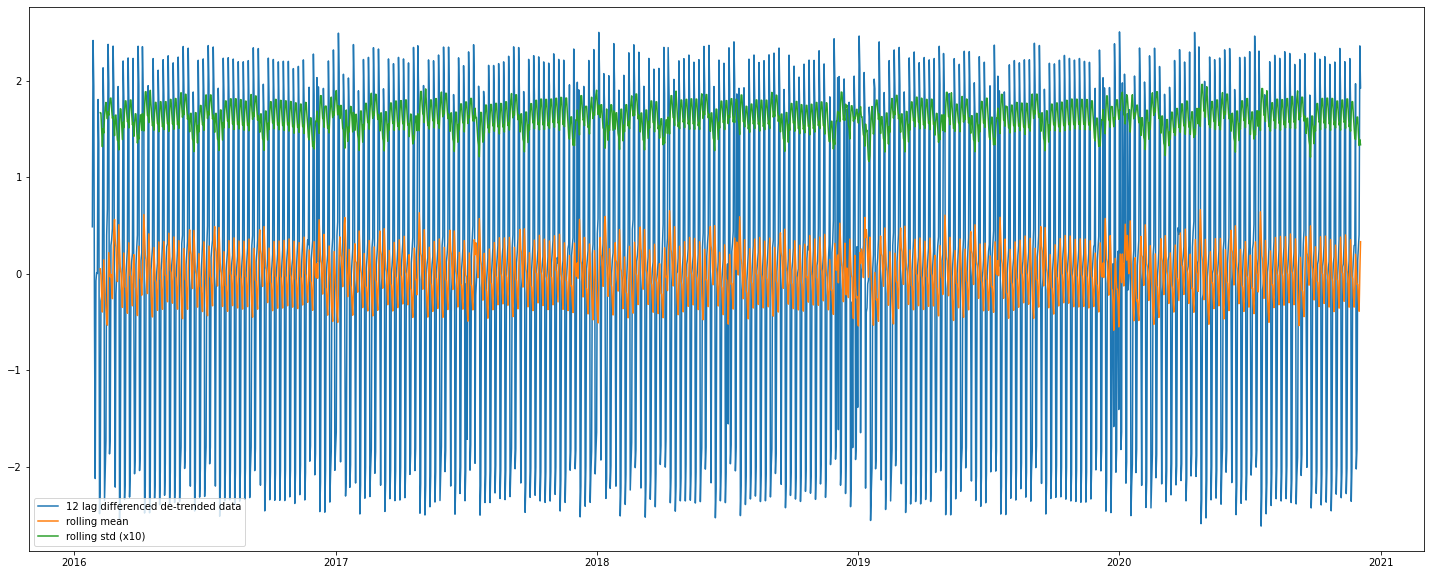

In [10]:
# Detrending + Differencing
adj_close_12lag_detrend =  adj_close_detrend - adj_close_detrend.shift(12)

test_stationarity(adj_close_12lag_detrend,'12 lag differenced de-trended data')
ADF_test(adj_close_12lag_detrend,'12 lag differenced de-trended data')

### Conclusion - Combining Detrending and Differencing method works best

statsmodels library, which has many statistical modeling functions, including time series.

Measure the quality of our predictions and take a look at the most commonly used metrics.

In [11]:
# Some metrics of prediction quality
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Different Time Series Prediction Models

Now that we know how to measure the quality of the forecasts, let's see what metrics we can use and how to translate the results. After that, one small detail remains - building the model.

### Simple models. Move, smoothe, evaluate
use the moving average.

$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k-1}_{n=0} y_{t-n}$

In [12]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(adj_close, 24) # prediction for the last observed day (past 24 hours)

4127.030808766683

We cannot make predictions far in the future -- in order to get the value for the next step, we need the previous values to be actually observed. But moving average has another use case - smoothing the original time series to identify trends. Pandas has an implementation available with DataFrame.rolling(window).mean(). The wider the window, the smoother the trend. In the case of very noisy data, which is often encountered in finance, this procedure can help detect common patterns.

In [13]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(25, 10))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

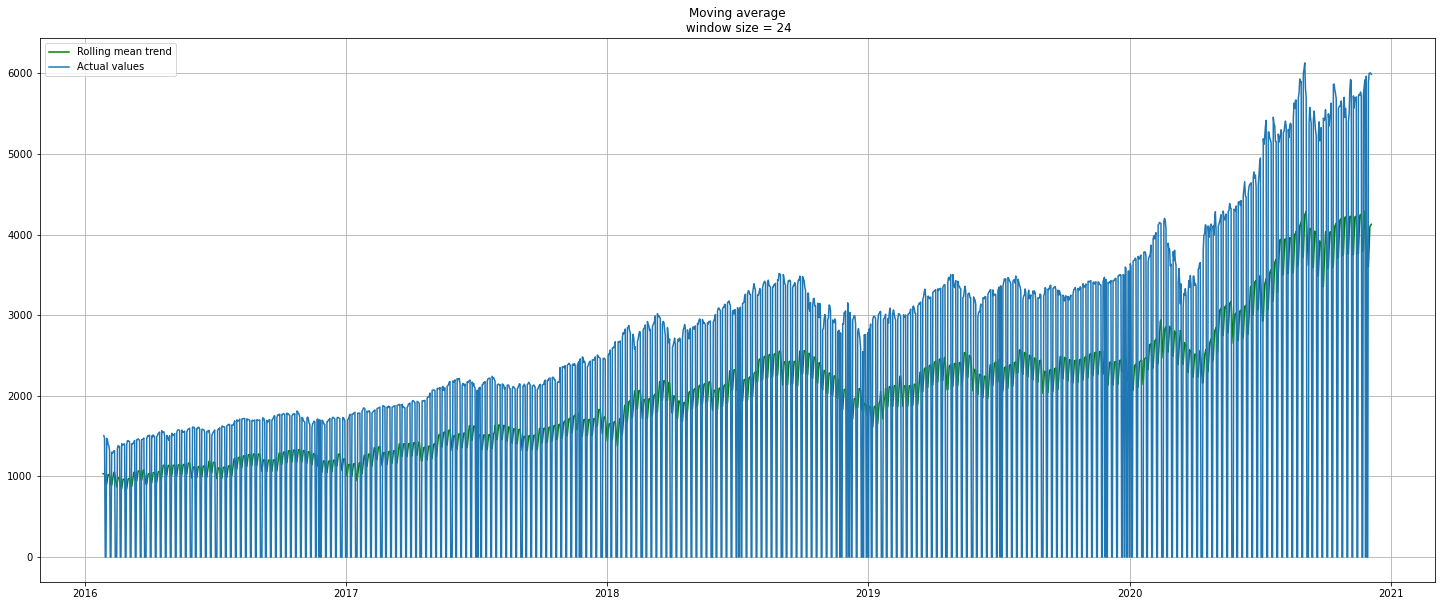

In [14]:
plotMovingAverage(adj_close, 24)

Weighted average is a simple modification to the moving average. 

The weights sum up to 1 with larger weights assigned to more recent observations.

$\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$

In [15]:
def weighted_average(series, weights):
    """
        Calculate weighter average on series
    """
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [16]:
weighted_average(adj_close, [0.6, 0.3, 0.1])

5998.315000534058

### Exponential smoothing
Now, let's see what happens if, instead of weighting the last  k  values of the time series, we start weighting all available observations while exponentially decreasing the weights as we move further back in time. There exists a formula for exponential smoothing that will help us with this:

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$
 
Here the model value is a weighted average between the current true value and the previous model values. The  α  weight is called a smoothing factor. It defines how quickly we will "forget" the last available true observation. The smaller  α  is, the more influence the previous observations have and the smoother the series is.

Exponentiality is hidden in the recursiveness of the function -- we multiply by  (1−α)  each time, which already contains a multiplication by  (1−α)  of previous model values.

In [17]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [18]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(25, 10))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

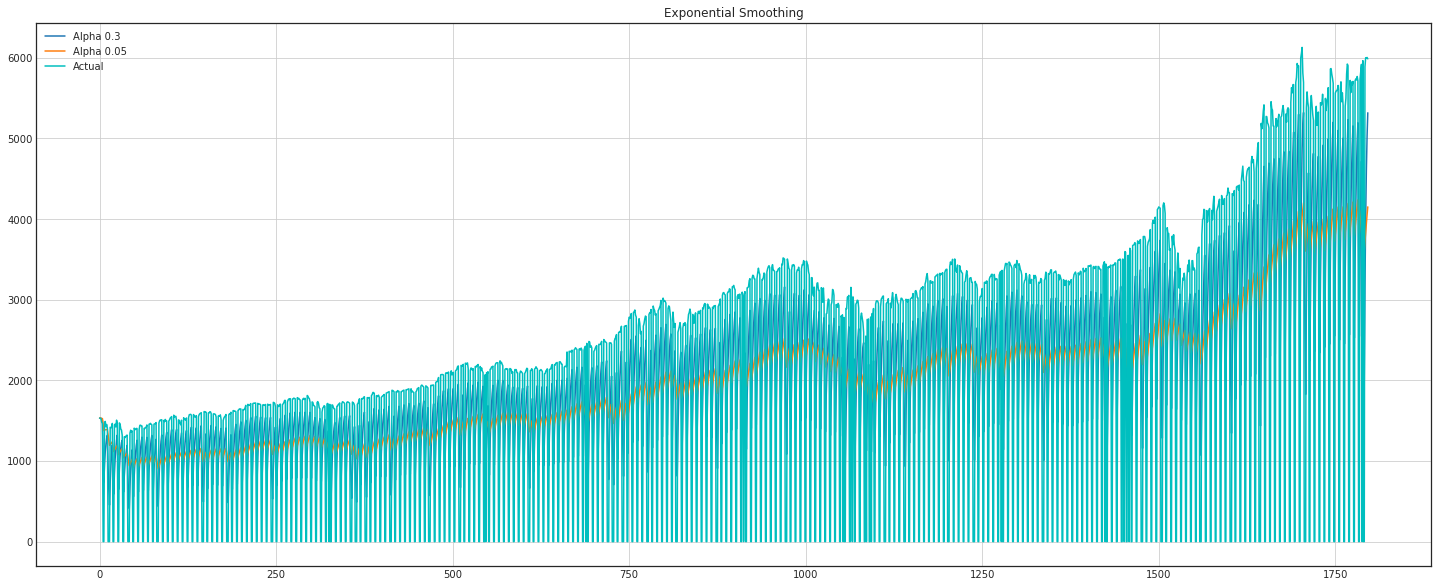

In [19]:
plotExponentialSmoothing(adj_close, [0.3, 0.05])

In [20]:
# Set the y_to_train, y_to_test, and the length of predict units
y_to_train = adj_close[:'2020-05-01'] # dataset to train
y_to_val = adj_close['2020-06-01':] # last X months for test  
predict_date = len(adj_close) - len(adj_close[:'2020-06-01']) # the number of data points for the test set

### Simple Exponential Smoothing
Suitable for time series data without trend or seasonal components

This model calculates the forecasting data using weighted averages.
One important parameter this model uses is the smoothing parameter: α, and you can pick a value between 0 and 1 to determine the smoothing level. When α = 0, the forecasts are equal to the average of the historical data. When α = 1, the forecasts will be equal to the value of the last observation.

In [21]:
def ses(adj_close, y_to_train, y_to_test, smoothing_level, predict_date):
    adj_close.plot(marker='o', color='black', legend=True, figsize=(25, 10))
    
    fit1 = SimpleExpSmoothing(y_to_train).fit(smoothing_level=smoothing_level,optimized=False)
    fcast1 = fit1.forecast(predict_date).rename(r'$\alpha={}$'.format(smoothing_level))
    # specific smoothing level
    fcast1.plot(marker='o', color='blue', legend=True)
    fit1.fittedvalues.plot(marker='o',  color='blue')
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with smoothing level of {} is {}'.format(smoothing_level,round(np.sqrt(mse1), 2)))
    
    ## auto optimization
    fit2 = SimpleExpSmoothing(y_to_train).fit()
    fcast2 = fit2.forecast(predict_date).rename(r'$\alpha=%s$'%fit2.model.params['smoothing_level'])
    # plot
    fcast2.plot(marker='o', color='green', legend=True)
    fit2.fittedvalues.plot(marker='o', color='green')
    
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with auto optimization is {}'.format(round(np.sqrt(mse2), 2)))
    
    plt.show()

The Root Mean Squared Error of our forecasts with smoothing level of 0.8 is 2458.99
The Root Mean Squared Error of our forecasts with auto optimization is 2693.59


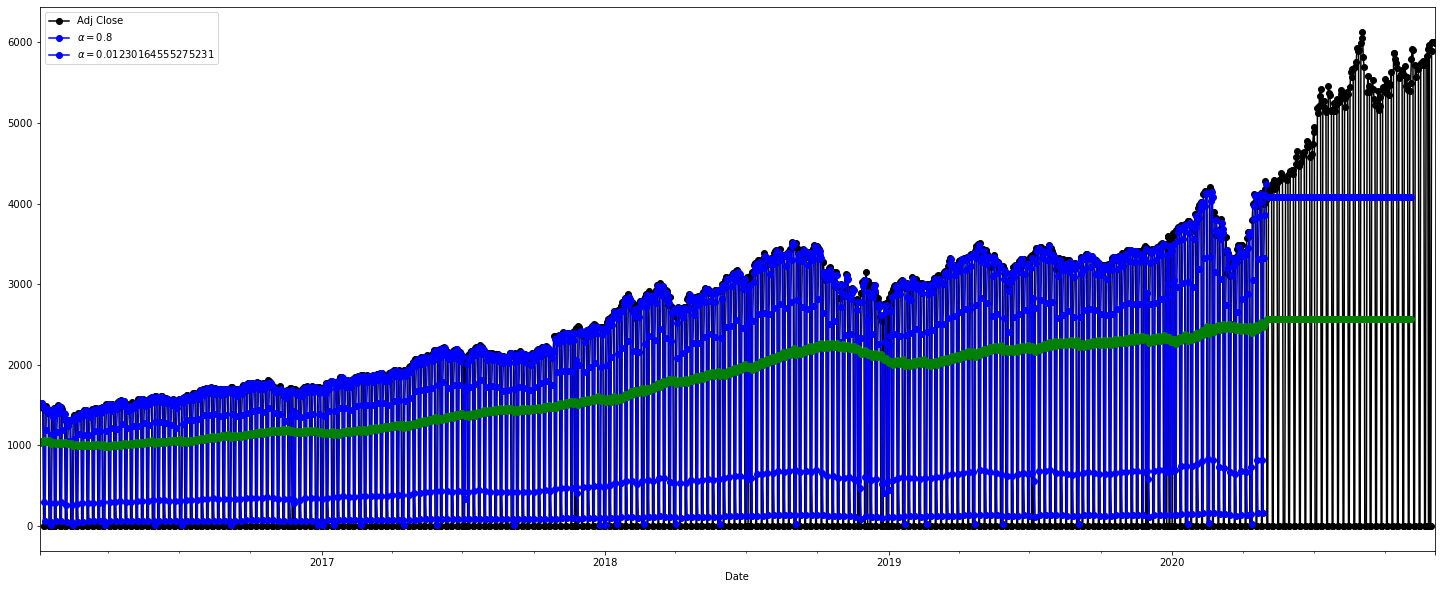

In [22]:
ses(adj_close, y_to_train, y_to_val, 0.8, predict_date)

The visualization of the results for the simple exponential smoothing (SES) forecast model shows the difference between the specified α (blue line) and the auto-optimized α (green line).

SES will predict a flat, forecasted line since the logic behind it uses weighted averages. Even though the RMSE is low, it does not predict any fluctuation. Since most time series data has some kind of trend or seasonality

### Exponential smoothing a.k.a. Holt-Winters
Suitable for time series data with trend and/or seasonal components.

With this, let's write out a new system of equations:

$\ell_x = \alpha(y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1})$

$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$

$s_x = \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L}$

$\hat{y}_{x+m} = \ell_x + mb_x + s_{x-L+1+(m-1)modL}$

The intercept now depends on the current value of the series minus any corresponding seasonal component. Trend remains unchanged, and the seasonal component depends on the current value of the series minus the intercept and on the previous value of the component. Take into account that the component is smoothed through all the available seasons; for example, if we have a Monday component, then it will only be averaged with other Mondays. You can read more on how averaging works and how the initial approximation of the trend and seasonal components is done here. Now that we have the seasonal component, we can predict not just one or two steps ahead but an arbitrary  m  future steps ahead, which is very encouraging.

Below is the code for a triple exponential smoothing model, which is also known by the last names of its creators, Charles Holt and his student Peter Winters. Additionally, the Brutlag method was included in the model to produce confidence intervals:

$\hat y_{max_x}=\ell_{x−1}+b_{x−1}+s_{x−T}+m⋅d_{t−T}$

$\hat y_{min_x}=\ell_{x−1}+b_{x−1}+s_{x−T}-m⋅d_{t−T}$

$d_t=\gamma∣y_t−\hat y_t∣+(1−\gamma)d_{t−T}$,

where $T$ - is the length of the season, $d$ - is the predicted deviation. Other parameters were taken from triple exponential smoothing. You can read more about the method and its applicability to anomaly detection in time series

In [23]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

That was Holt-Winters model with the anomalies detection using Brutlag method

### Time series cross validation
slen=24 parameter.

We train our model on a small segment of the time series from the beginning until some  t , make predictions for the next  t+n  steps, and calculate an error. Then, we expand our training sample to  t+n  value, make predictions from  t+n  until  t+2∗n , and continue moving our test segment of the time series until we hit the last available observation. As a result, we have as many folds as  n  will fit between the initial training sample and the last observation.

In [24]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(x):
    # error vector
    errors = []
    
    values = data.values
    alpha, beta, gamma = x
    
    # Adding the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # go through folds, train the model on each one, build a forecast on the deferred sample and calculate the error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 24*7, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)
    return np.mean(np.array(errors))

In the Holt-Winters model, as well as in the other models of exponential smoothing, there's a constraint on how large the smoothing parameters can be, each of them ranging from 0 to 1. Therefore, in order to minimize our loss function, we have to choose an algorithm that supports constraints on model parameters. In our case, we will use the truncated Newton conjugate gradient.

In [25]:
%%time
data = adj_close[:-100] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# Take optimal values..
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.02087117643238673 0.0 0.5840716753122314
Wall time: 10.3 s


#### We transfer the obtained optimal values of the coefficients $\alpha$, $\beta$ и $\gamma$ and build a forecast for 5 days ahead (120 hours)

In [26]:
# Passing the optimal values to the model
data = adj_close
model = HoltWinters(data[:-120], slen = 24*7, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 120, 
                    scaling_factor = 2.56)

model.triple_exponential_smoothing()

In [27]:
# Code for plotting a graph
def plotHoltWinters():
    Anomalies = np.array([np.NaN]*len(data))
    Anomalies[data.values<model.LowerBond] = data.values[data.values<model.LowerBond]
    plt.figure(figsize=(25, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
    plt.plot(data.values, label = "Actual")
    plt.plot(Anomalies, "o", markersize=10, label = "Anomalies")
    plt.axvspan(len(data)-120, len(data), alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

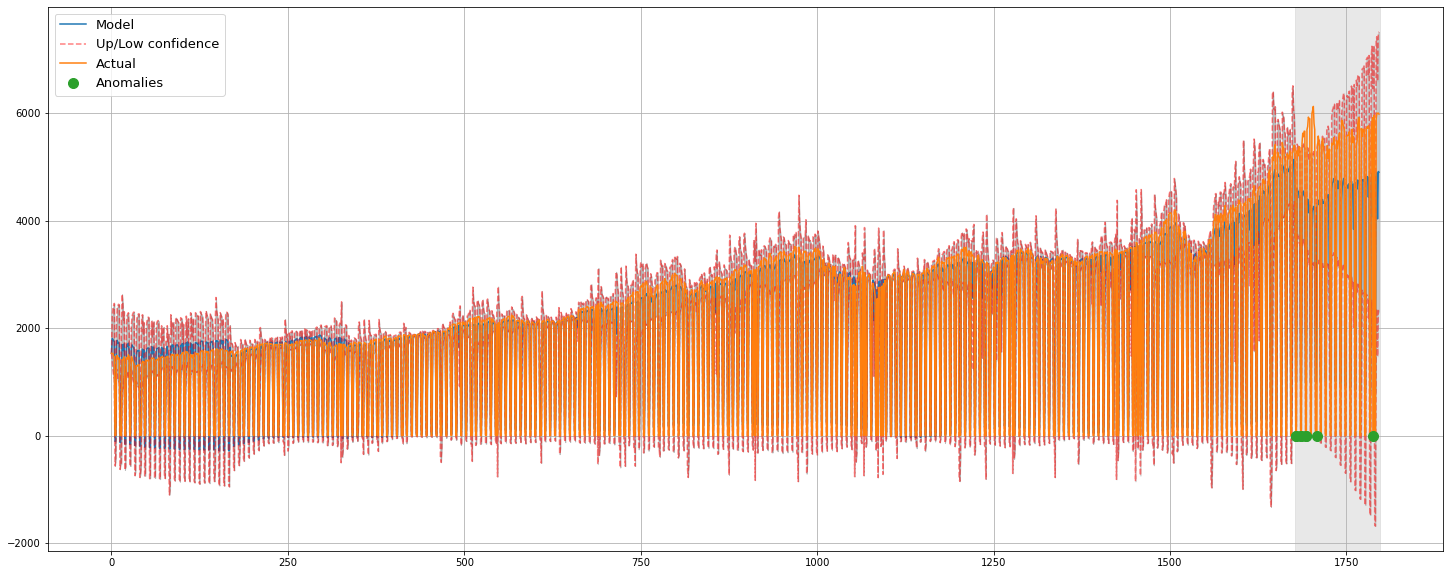

In [28]:
plotHoltWinters()

Judging by the graph, the model described the initial time series well, capturing weekly and daily seasonality, and was even able to catch abnormal declines that went beyond the confidence intervals. If you look at the modeled deviation, you can clearly see that the model quite abruptly registers for significant changes in the structure of the series, but at the same time quickly returns the variance to its usual values, "forgetting" the past. This feature allows you to set up a system for detecting anomalies quite well and without significant costs for training the model, even in rather noisy rows.

#### Brutlag

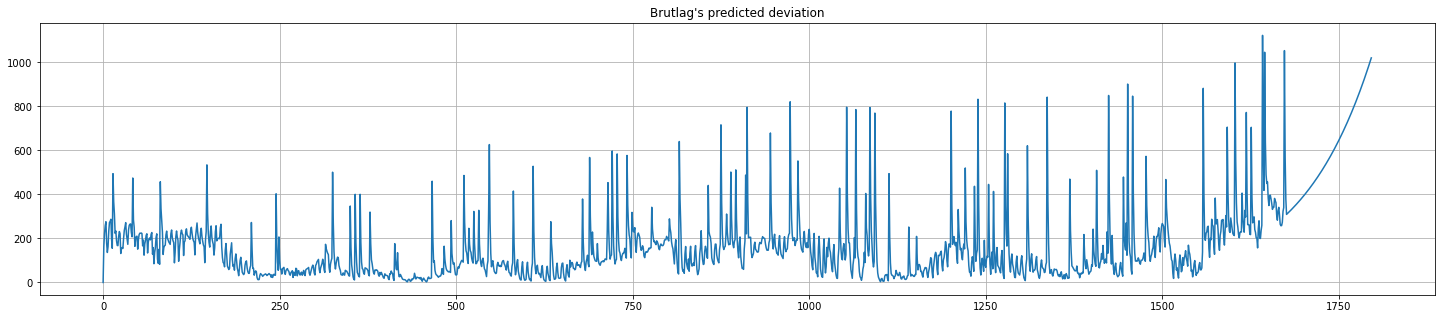

In [29]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

### Getting rid of non-stationarity and building SARIMA
Build an ARIMA model making a series stationary.

In [30]:
# Code to render plots.
def tsplot(y, lags=None, figsize=(25, 10), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

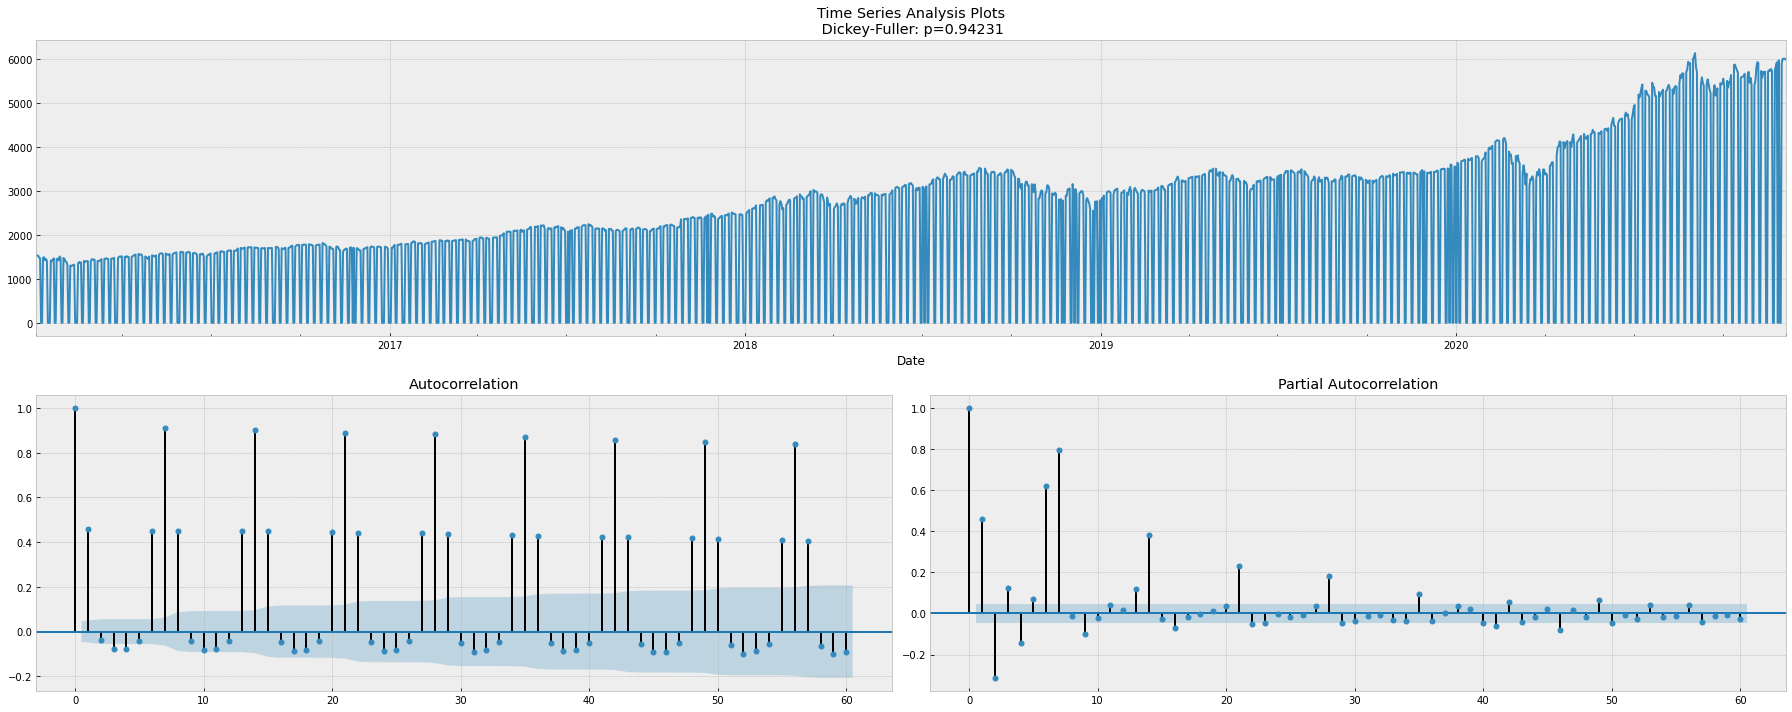

In [31]:
tsplot(adj_close, lags=60)

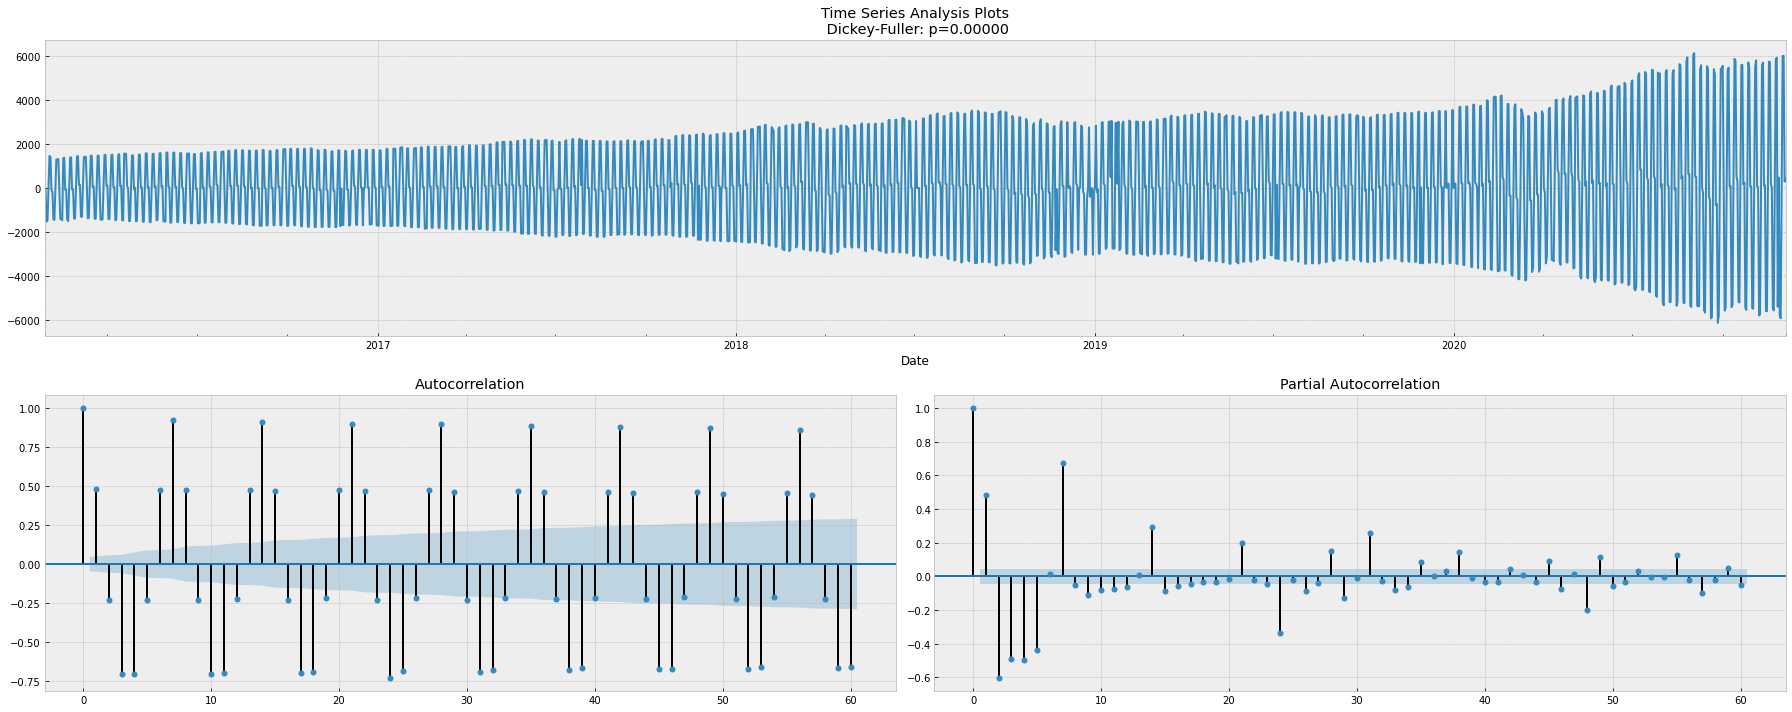

In [32]:
adj_close_diff = adj_close - adj_close.shift(24)
tsplot(adj_close_diff[24:], lags=60)

The Dickey-Fuller test indicates that it is stationary, and the number of significant peaks in ACF has dropped. We can finally start modeling

### ARIMA
We will explain this model by building up letter by letter.  SARIMA(p,d,q)(P,D,Q,s) , Seasonal Autoregression Moving Average model:

* AR(p)  - autoregression model i.e. regression of the time series onto itself. The basic assumption is that the current series values depend on its previous values with some lag (or several lags). The maximum lag in the model is referred to as  p . To determine the initial  p , you need to look at the PACF plot and find the biggest significant lag after which most other lags become insignificant.

* MA(q)  - moving average model. Without going into too much detail, this models the error of the time series, again with the assumption that the current error depends on the previous with some lag, which is referred to as  q . The initial value can be found on the ACF plot with the same logic as before.
Let's combine our first 4 letters:

* AR(p)+MA(q)=ARMA(p,q) 
What we have here is the Autoregressive–moving-average model! If the series is stationary, it can be approximated with these 4 letters. Let's continue.

So SARIMA includes several parameters that can be tuned to achieve optimal performance.

Trend Elements:

* p: Trend autoregression order.

* d: Trend difference order.

* q: Trend moving average order.

Seasonal Elements:

* P: Seasonal autoregressive order.

* D: Seasonal difference order.

* Q: Seasonal moving average order.

* m: The number of time steps for a single seasonal period.

The evaluation metric we’ll use for the grid search is the AIC (Akaike Information Criterion) value. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. In general, we want to pick the combination with the lowest AIC value.

In [33]:
def sarima_grid_search(adj_close, seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(adj_close,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

The grid search tested all possible combinations of variables, and printed out the set that resulted in the lowest AIC.

And we can see that SARIMA(1, 1, 1)x(1, 1, 0, 52) has the lowest AIC value. 

Since this method chose the best parameters, we will use this method to fit our model and compare the results with all the previous models discussed above.

In [34]:
%time
sarima_grid_search(adj_close, 52)

Wall time: 0 ns
The set of parameters with the minimum AIC is: SARIMA(0, 1, 1)x(1, 1, 1, 52) - AIC:29346.126401461537


In addition to using the Root Mean Squared Error (RMSE) metric, I also ran plot_diagnostics( ), to ensure that none of the assumptions made by the model have been violated, and that there is no unusual behavior. 

The dynamic=False argument ensures that we produce one-step-ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.

In [35]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(adj_close, order,seasonal_order, seasonal_period, pred_date, y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(adj_close,
                                    order=order,
                                    seasonal_order=seasonal_order,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(25, 10))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = adj_close.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(25, 10))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Adj Close')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = adj_close.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(25, 10))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Adj Close')

    plt.legend()
    plt.show()
    
    return (results)

Here are the visualizations for the SARIMA method. Compared with the results of all the previous models, we can be confident saying the SARIMA model best captures both the seasonality and trend of our dataset. Its forecasted results are closest to the actual sales.

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1330      0.026      5.169      0.000       0.083       0.183
ma.L1         -1.0045      0.002   -507.884      0.000      -1.008      -1.001
ar.S.L52      -0.7462      0.017    -42.993      0.000      -0.780      -0.712
sigma2      2.569e+06    2.5e-09   1.03e+15      0.000    2.57e+06    2.57e+06


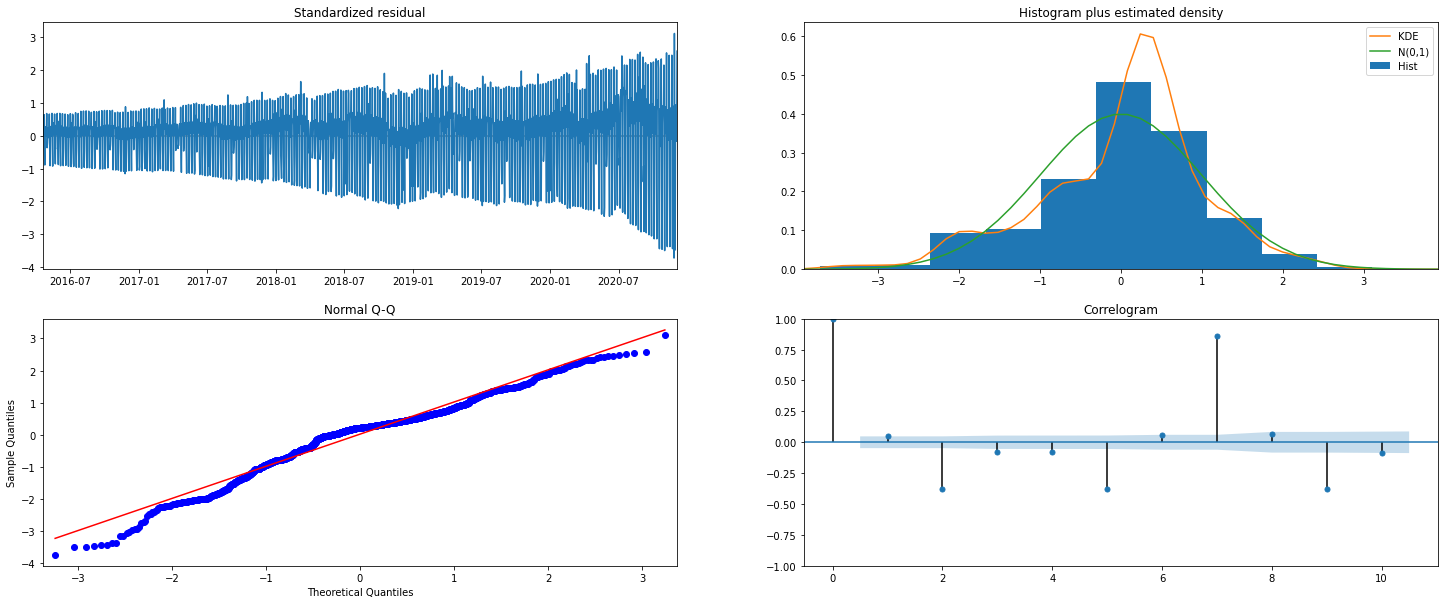

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = False 2660.63


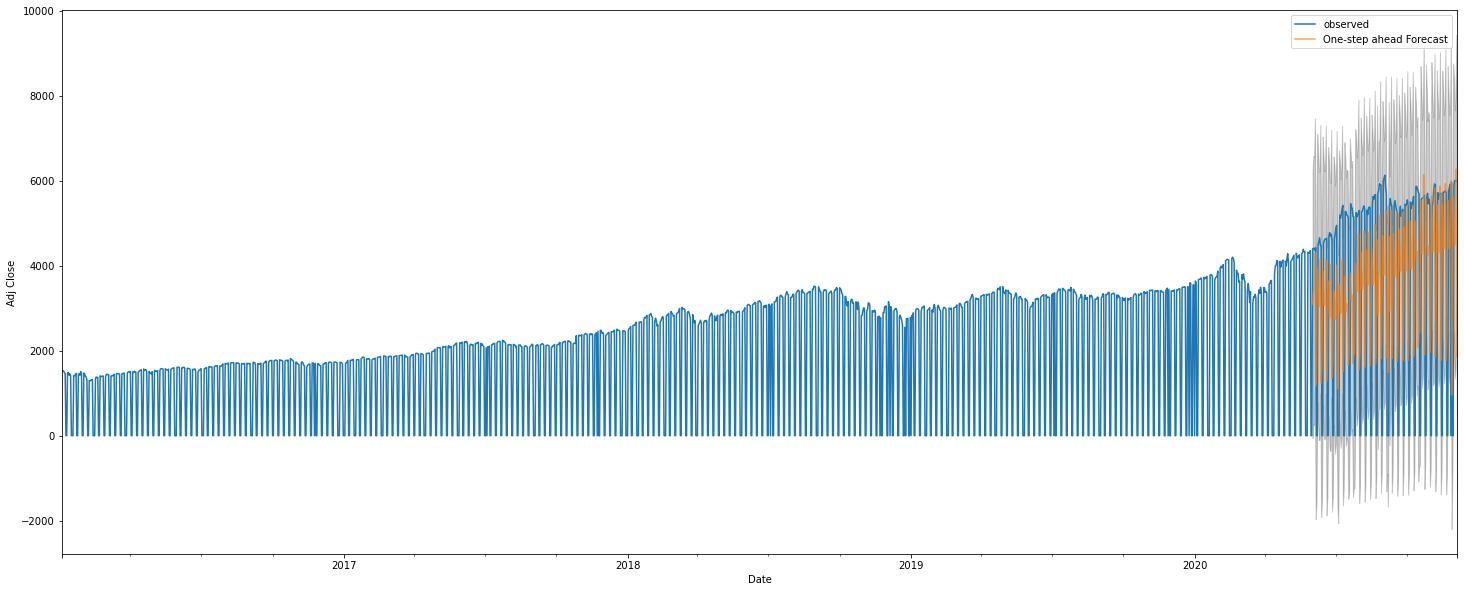

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = True 2948.96


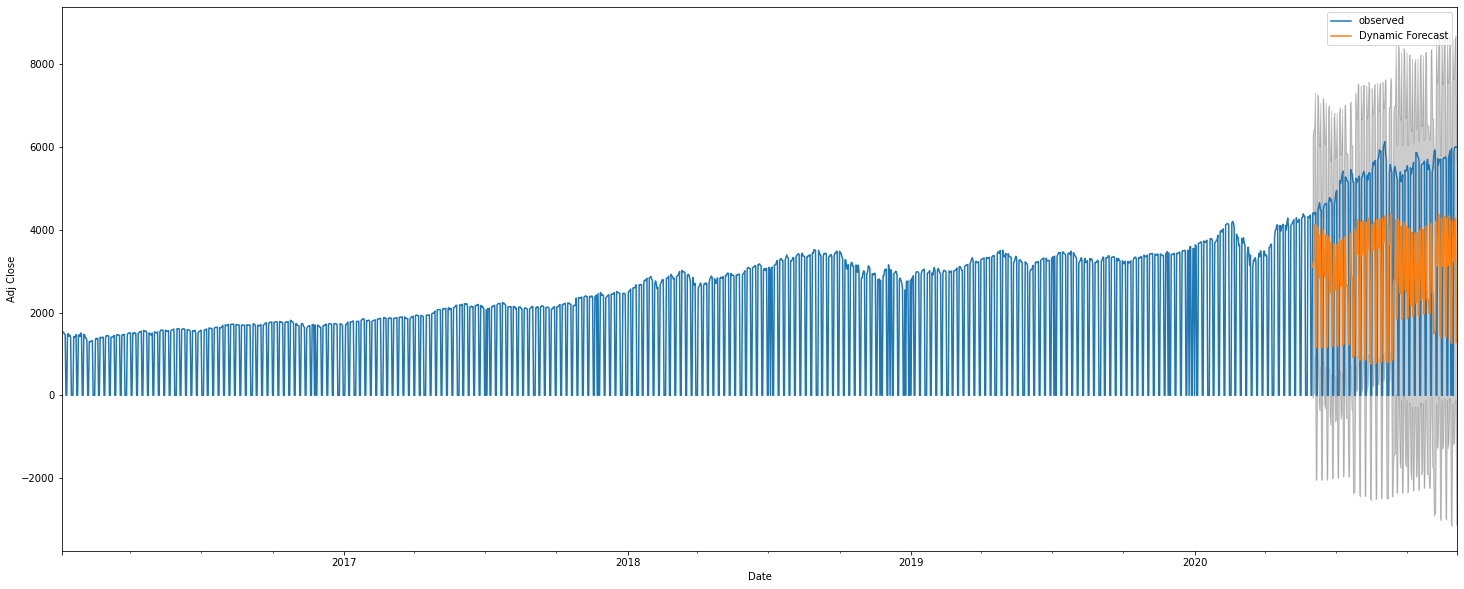

In [36]:
model = sarima_eva(adj_close, (1, 1, 1), (1, 1, 0, 52), 52, '2020-06-01', y_to_val)

There are a few things to check to help diagnostic graphs:

1. The top left plot shows the residuals over time. We do not want to see any obvious seasonality here and the messier it is, the better we can say we found the trend and seasonality in our data and removed the noise.

2. In the top-right plot, we want to see that the red KDE line follows closely with the N(0,1) line to indicate that the residuals are normally distributed. This line is the standard notation for a normal distribution with a mean of 0 and a standard deviation of 1.

3. In the bottom left qq-plot, you see the ordered distribution of residuals (blue dots) following the linear trend (red line) of the samples taken from a standard normal distribution with N(0, 1).

4. The autocorrelation visual (called a “correlogram”) on the bottom right shows that the time series residuals have a low correlation with the lagged versions of itself (that is, the majority of dots fall into the blue shaded area).

I can conclude that this model’s residuals are near normally distributed. 
This indicates we have found a well-fit model suitable for our dataset.

* To get the forecast for sales in the next year, we enter steps=52(days). The results produce both a table showing the Predicted_Mean, Lower Bound and Upper Bound, and the prediction graphs.

In [37]:
def forecast(model, predict_steps, adj_close):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    # SARIMAXResults.conf_int, can change alpha,the default alpha = 0.05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = adj_close.plot(label='observed', figsize=(25, 10))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(adj_close.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

* Visualization that our model clearly captured the seasonality as well as the increasing trend of the sales.

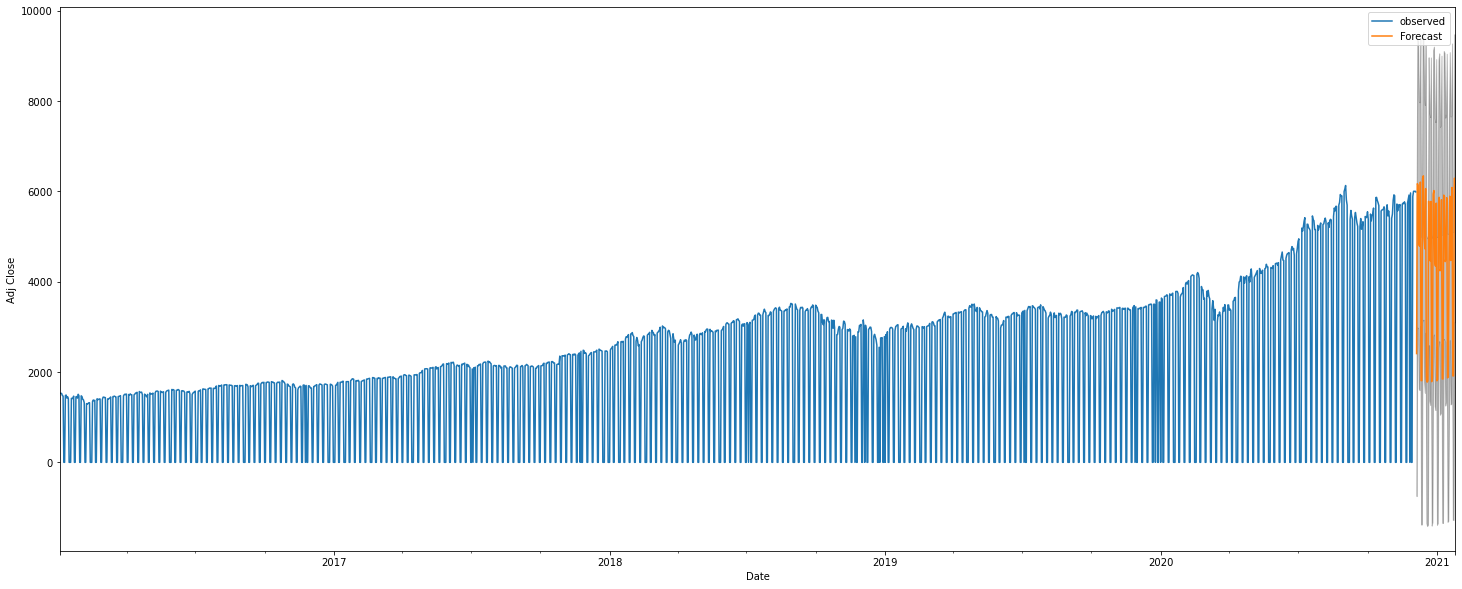

Date  Predicted_Mean   Lower Bound   Upper Bound
0 2020-12-05   2407.53307261 -747.84590073 5562.91204596
1 2020-12-06   6169.64801428 2984.59683612 9354.69919243
2 2020-12-07   6137.42074146 2951.56031975 9323.28116318
3 2020-12-08   4815.62431937 1629.67597566 8001.57266308
4 2020-12-09   4785.27065884 1599.27551952 7971.26579817

In [38]:
final_table = forecast(model, 52, adj_close)
final_table.head()

* The orange line in the graph represents the expected future data based on the forecasting model. 

* The blue line represents the average forecasted value for each week.

The gray area above and below the orange line represents the 95 percent confidence interval and as with virtually all forecasting models, as the predictions go further into the future, the less confidence we have in our values.

In this case, we are 95 percent confident that the actual sales will fall inside this range. But, there is a chance the actuals could fall completely outside this range also. The larger the future time period for which we want to predict, the larger this confidence range will be (that is, the less precise our forecast is).

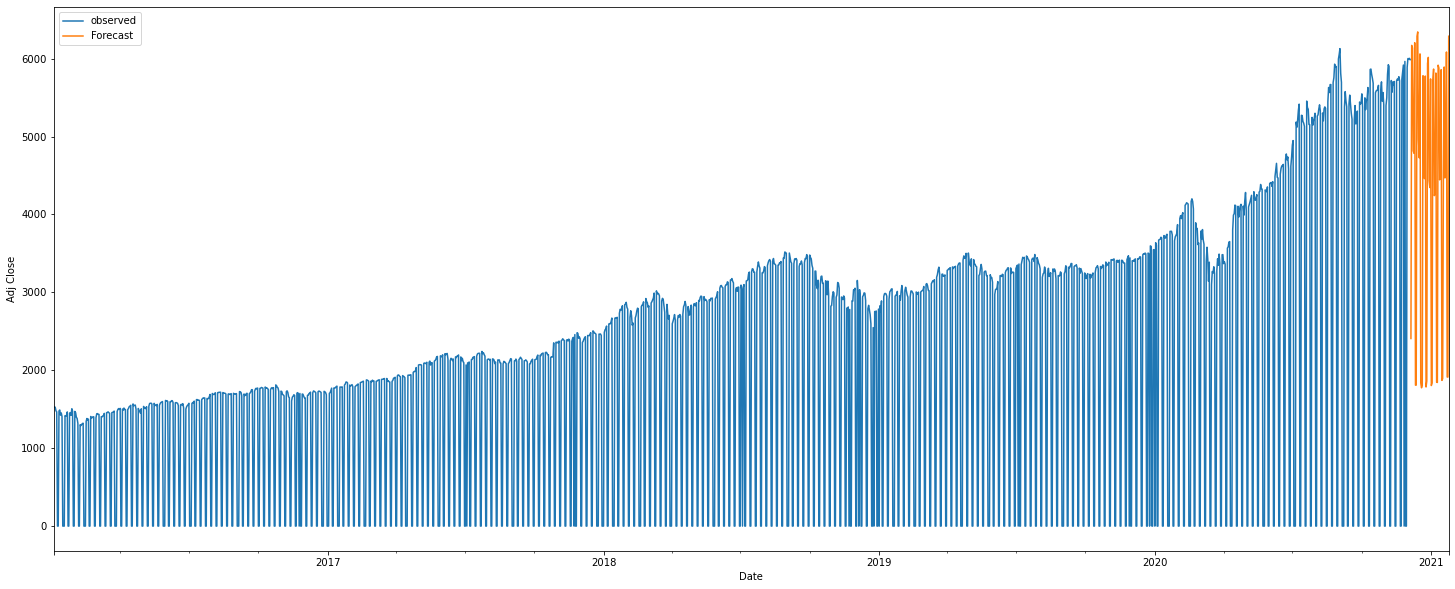

In [39]:
# Graphs without the confident interval 
pred_uc = model.get_forecast(steps=51)
ax = adj_close.plot(label='observed', figsize=(25, 10))
#     print(pred_uc.predicted_mean)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel(adj_close.name)

plt.legend()
plt.show()

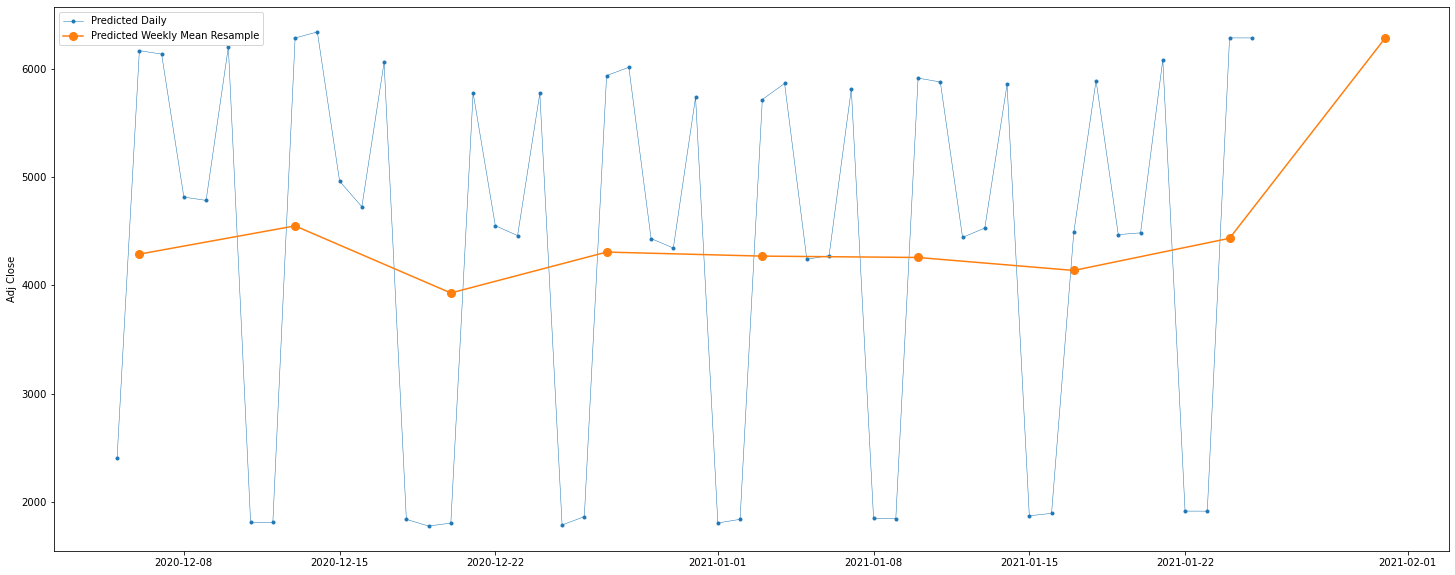

In [40]:
# Graphs show only the perdiected period
final_table.index = final_table.Date
fig, ax = plt.subplots(figsize=(25, 10))
# ax.plot(adj_close,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(final_table.Predicted_Mean, marker='.', linestyle='-', linewidth=0.5, label='Predicted Daily')
# ax.plot(adj_close.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.plot(final_table.Predicted_Mean.resample('W').mean(), marker='o', markersize=8, linestyle='-', label='Predicted Weekly Mean Resample')
ax.set_ylabel('Adj Close')
ax.legend();